In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc3 as pm
import arviz as az

az.style.use('arviz-darkgrid')

In [2]:
# Data taken from Kruschke (Chapter 21)
df = pd.read_csv('HtWtData110.csv')
df

,male,height,weight
0,0,63.2,168.7
1,0,68.7,169.8
2,0,64.8,176.6
3,0,67.9,246.8
4,1,68.9,151.6
...,...,...,...
105,1,69.9,174.5
106,1,73.2,221.6
107,0,61.9,160.6
108,0,66.1,117.1


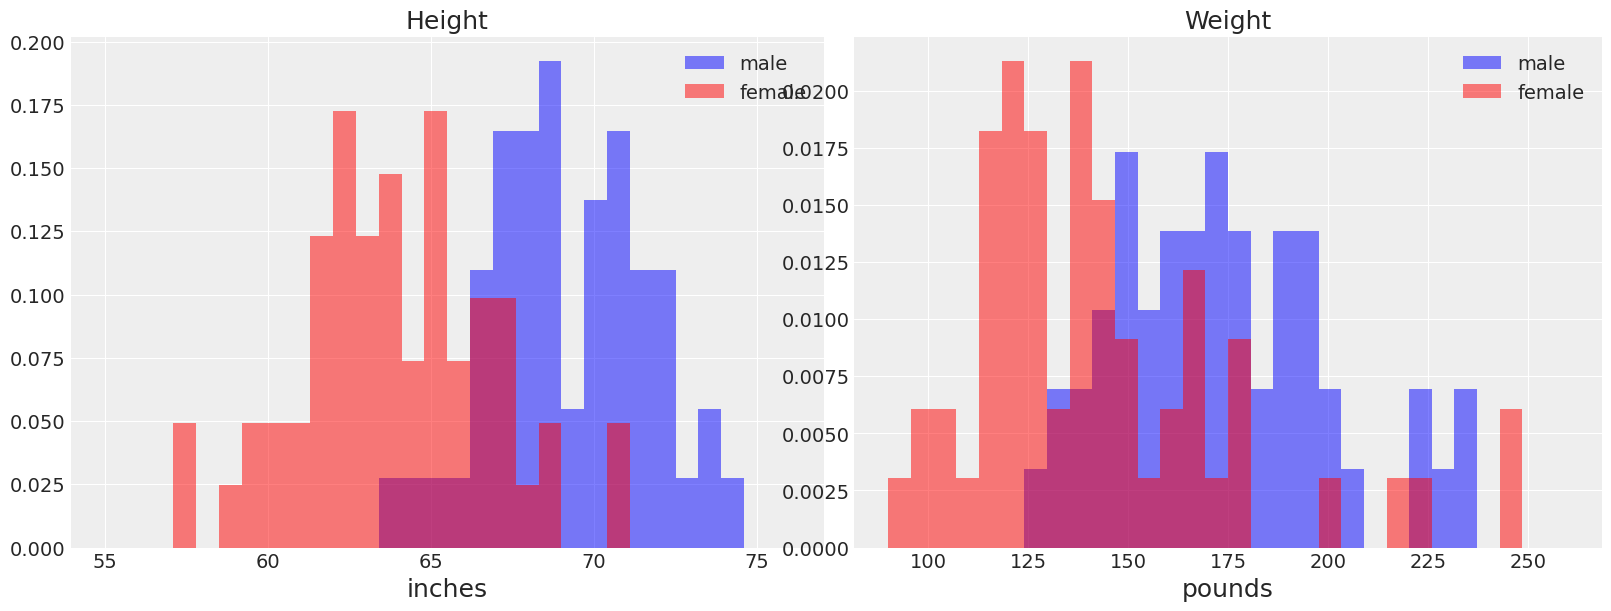

In [3]:
plt.figure(figsize=(16, 6))

# height
plt.subplot(1, 2, 1)
plt.title('Height', fontsize=18)
plt.xlabel('inches', fontsize=18)
_, bins, _ = plt.hist(df[df.male==1].height, bins=30, range=[55, 76], 
                      density=True, alpha=0.5, color='blue', label='male')
plt.hist(df[df.male==0].height, bins=bins, density=True, alpha=0.5, color='red', label='female')
plt.legend()

# weight
plt.subplot(1, 2, 2)
plt.title('Weight', fontsize=18)
plt.xlabel('pounds', fontsize=18)
_, bins, _ = plt.hist(df[df.male==1].weight, bins=30, range=[90, 260], 
                      density=True, alpha=0.5, color='blue', label='male')
plt.hist(df[df.male==0].weight, bins=bins, density=True, alpha=0.5, color='red', label='female')
plt.legend()

plt.show()

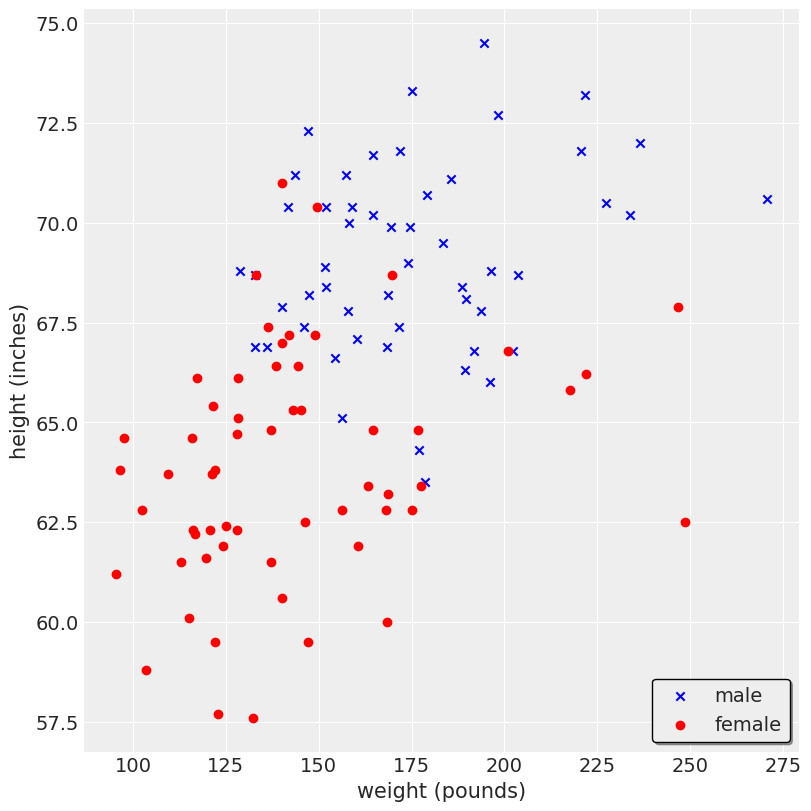

In [4]:
# explore the data
plt.figure(figsize=(8,8))
plt.scatter(df[df.male==1].weight, df[df.male==1].height,
            marker='x', label='male', c='blue')
plt.scatter(df[df.male==0].weight, df[df.male==0].height,
            marker='o', label='female', c='red')
plt.legend(loc='lower right', shadow=True, edgecolor='k', frameon='True')
plt.xlabel('weight (pounds)')
plt.ylabel('height (inches)')
plt.show()

### MCMC approach
Model:

$$
t_i | x_i, \mathbf w \sim \mathrm{Be}(\theta(\mathbf x_i))
\\
\theta(x) = \mathrm{logit}(\mathbf w^T \mathbf x)
\\
\mathbf w_j \sim  \mathcal N(0, S_j)
$$

In [5]:
# collect data
X = np.stack([df.weight, df.height], axis=-1)
t = df.male
print('X.shape=', X.shape)
print('t.shape=', t.shape)

X.shape= (110, 2)
t.shape= (110,)


In [6]:
# normalize data and append ones
x_means = X.mean(axis=0)
print('x_means=', x_means)
x_scales = X.std(axis=0)
print('x_scales=', x_scales)
zX = ((X-x_means)/x_scales)
zX = np.hstack([np.ones(shape=(zX.shape[0], 1)), zX])
zX.shape

x_means= [158.31090909  66.36363636]
x_scales= [35.51023756  3.73043325]


(110, 3)

In [7]:
zX[:10]

array([[ 1.        ,  0.29256608, -0.84806138],
       [ 1.        ,  0.32354306,  0.6262982 ],
       [ 1.        ,  0.51503713, -0.41915677],
       [ 1.        ,  2.49193182,  0.4118459 ],
       [ 1.        , -0.18898519,  0.67991128],
       [ 1.        , -0.00875548,  0.38503936],
       [ 1.        ,  0.28974999,  0.49226551],
       [ 1.        , -0.59450205, -0.41915677],
       [ 1.        ,  0.52630149, -0.55318946],
       [ 1.        , -0.85358227, -0.44596331]])

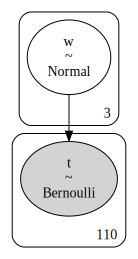

In [8]:
with pm.Model() as model:
    w = pm.Normal('w', mu=0, sd=np.array([10, 2, 2]), shape=(3))  # sd=10 for w0 and sd=2 for predictors
    # invlogit func is the same as logistic func:
    theta = pm.invlogit(pm.math.dot(w, zX.T))
    outputs = pm.Bernoulli('t', theta, observed=t)
    
pm.model_to_graphviz(model)

In [9]:
with model:
    trace = pm.sample(draws=2000, tune=1000, chains=4, cores=2,
                      return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [w]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


In [10]:
trace.posterior['w'].shape

(4, 2000, 3)

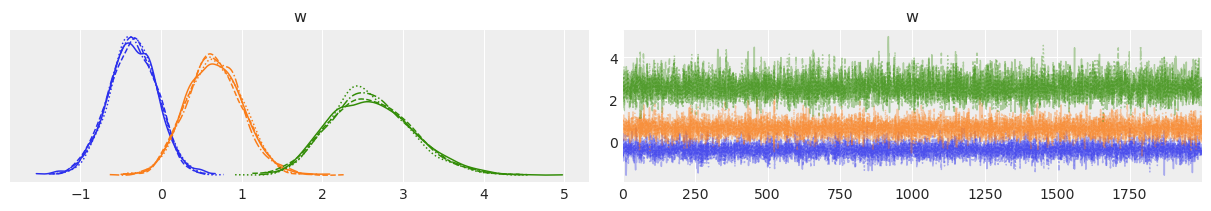

In [11]:
az.plot_trace(trace, #compact=False
             );

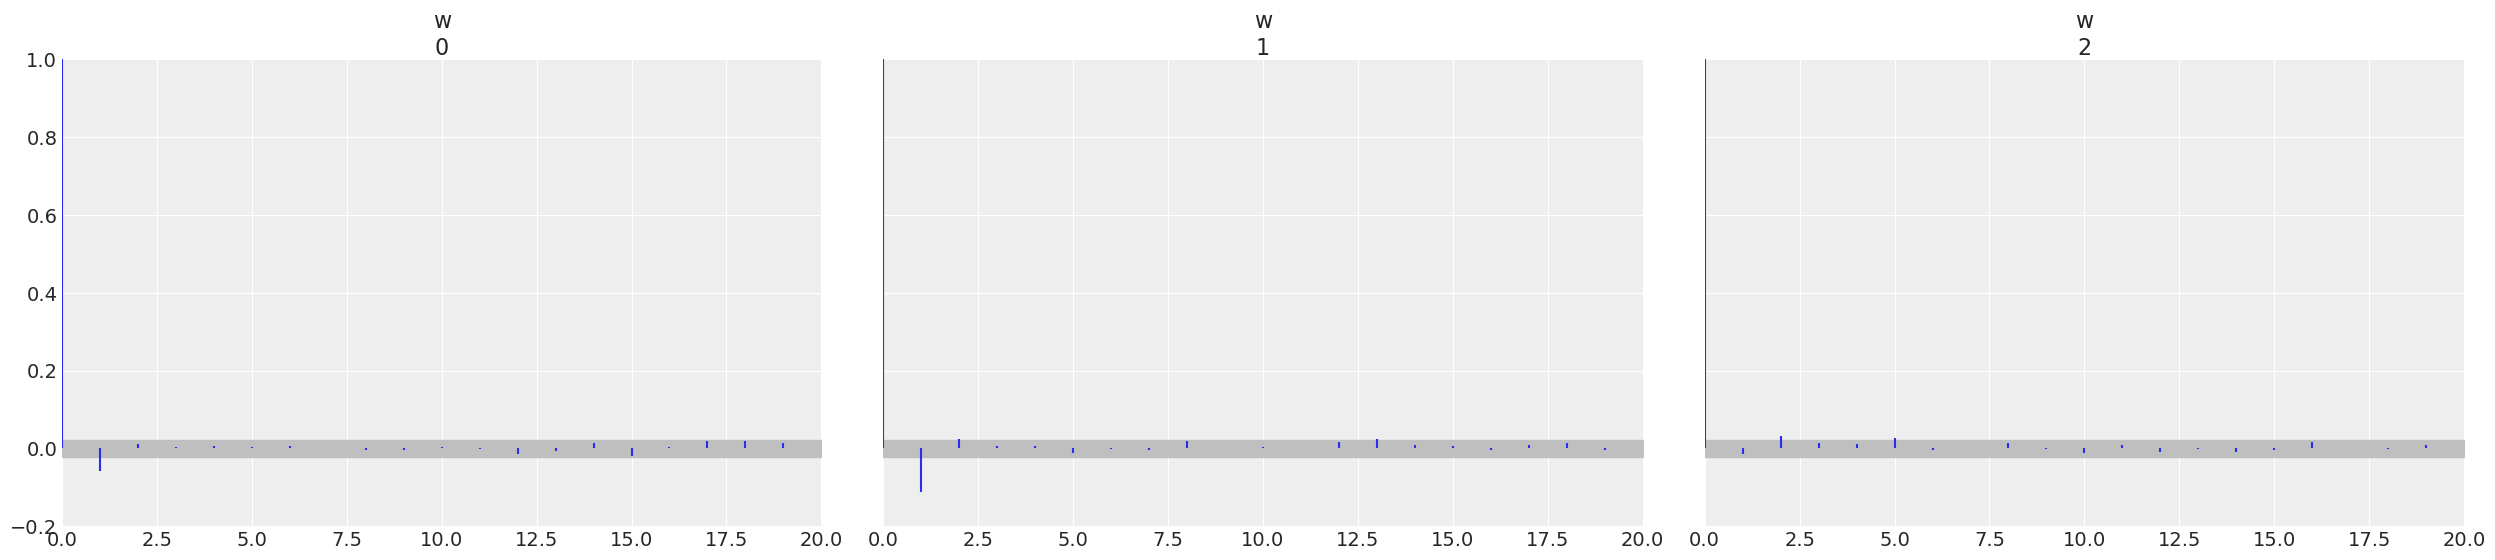

In [12]:
az.plot_autocorr(trace, max_lag=20, combined=True)
plt.ylim([-0.2, 1]);

In [13]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],-0.355,0.301,-0.934,0.185,0.003,0.003,8604.0,5753.0,1.0
w[1],0.663,0.346,0.036,1.325,0.004,0.003,9563.0,5860.0,1.0
w[2],2.604,0.511,1.711,3.611,0.006,0.004,7249.0,5247.0,1.0


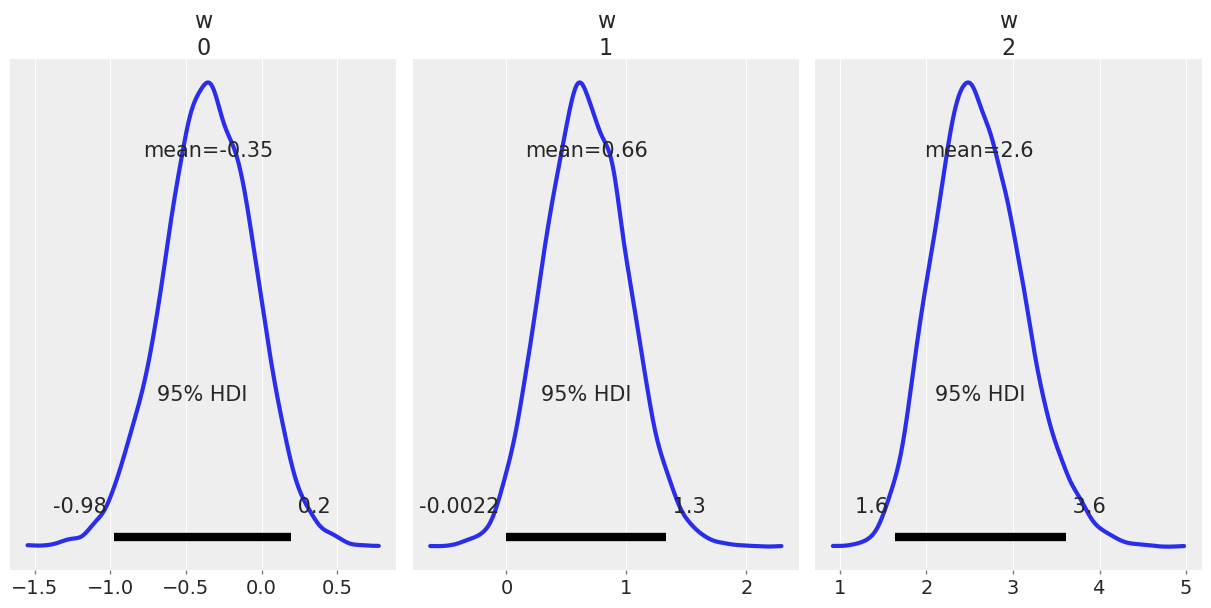

In [14]:
az.plot_posterior(trace, hdi_prob=0.95,
                  figsize=(12,6), lw=3);

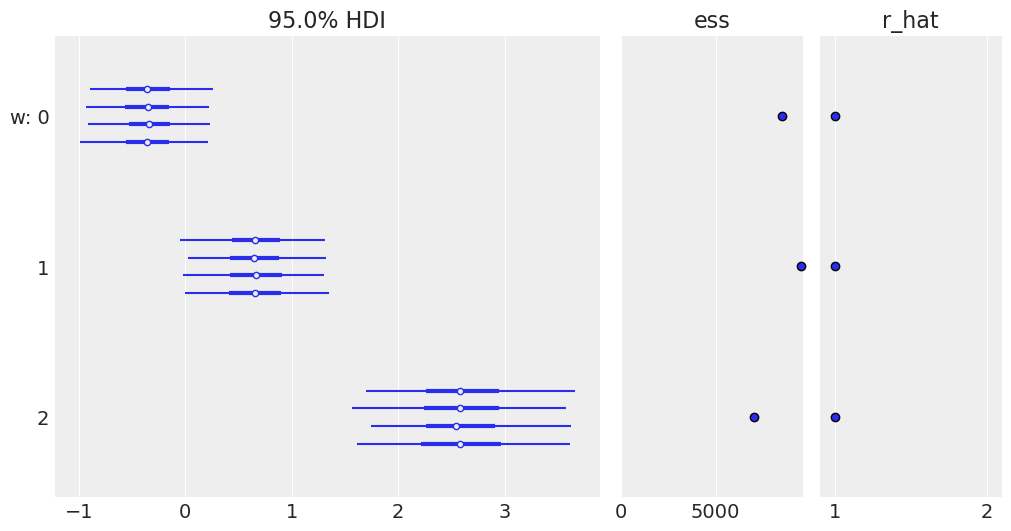

In [15]:
az.plot_forest(trace, hdi_prob=0.95,
               r_hat=True, ess=True);

In [16]:
# transform weights back to original scale
w0_trace = trace.posterior['w'][...,0].values.reshape(-1)
w1_trace = trace.posterior['w'][...,1].values.reshape(-1)
w2_trace = trace.posterior['w'][...,2].values.reshape(-1)

w0_trace -= x_means[0] / x_scales[0] * w1_trace + x_means[1] / x_scales[1] * w2_trace
w1_trace /= x_scales[0]
w2_trace /= x_scales[1]

w_trace = np.stack([w0_trace, w1_trace, w2_trace], axis=-1)
w_trace.shape

(8000, 3)

Boundary Decision:

$\theta(\mathbf x = 0.5) \qquad \Longleftrightarrow \qquad \mathbf w^T \mathbf x = 0$

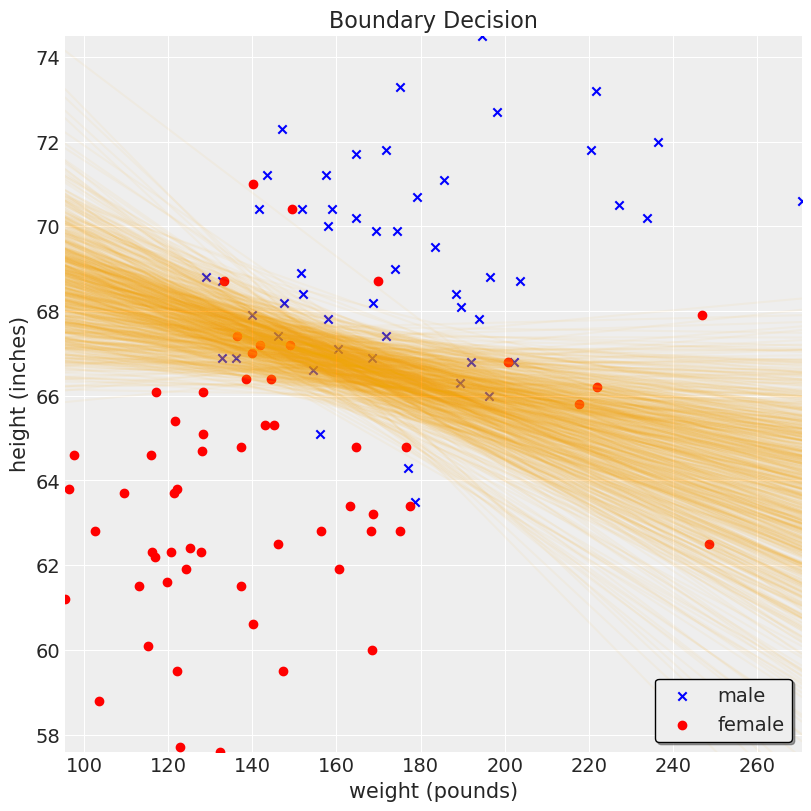

In [17]:
# samples of boundary decision:

plt.figure(figsize=(8,8))
plt.title('Boundary Decision')
plt.scatter(df[df.male==1].weight, df[df.male==1].height,
            marker='x', label='male', c='blue')
plt.scatter(df[df.male==0].weight, df[df.male==0].height,
            marker='o', label='female', c='red')
x1_grid = np.linspace(df.weight.min(), df.weight.max(), 2)
for i in np.arange(0, len(w0_trace), 10):
    x2 = -w0_trace[i]/w2_trace[i] - w1_trace[i]/w2_trace[i]*x1_grid
    plt.plot(x1_grid, x2, color='orange', alpha=0.05)

plt.xlim(df.weight.min(), df.weight.max())
plt.ylim(df.height.min(), df.height.max())
plt.legend(loc='lower right', shadow=True, edgecolor='k', frameon='True')
plt.xlabel('weight (pounds)')
plt.ylabel('height (inches)')
plt.show()

### Prediction of new data

In [18]:
X_new = np.array([1, 200, 70]) # one point

In [19]:
from scipy.stats import logistic
male_prob = logistic.cdf(w_trace.dot(X_new))

In [20]:
print('male_prob.shape=', male_prob.shape)
print('male_prob.mean=', male_prob.mean())
print('male_prob.std=', male_prob.std())

male_prob.shape= (8000,)
male_prob.mean= 0.942350309772722
male_prob.std= 0.03343191293346312


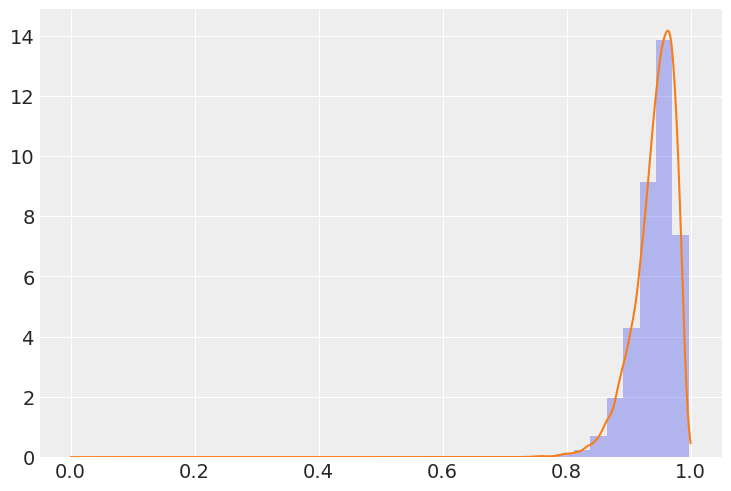

In [21]:
plt.hist(male_prob, density=True, alpha=0.3)
kde = stats.gaussian_kde(male_prob)
xx = np.linspace(0, 1, 1000)
plt.plot(xx, kde(xx));